In [373]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm,multivariate_normal
from sklearn.mixture import GaussianMixture as GMM
from statsmodels.tsa.stattools import adfuller

In [374]:
def markedDepenenceLambda(beta,value):
    p=-(np.log(1-value))/beta
    return p

def markFunction(A,alpha,mark):
    return A*np.exp(alpha*mark)


def function_kernel1(theta,tau):
    kernel=(np.exp(-theta*tau))
    return kernel

def function_kernel2(theta,tau):
    kernel=np.ones(len(tau))*0.01
    return kernel



def simu_multivariateMarked(mus,thetas,betas,T):    
    totalD=len(mus)
    timesteps=[[] for d in range(totalD)]
    l2Marks=[[[]for d in range(totalD)] for d in range(totalD)]
    tmax=0
    while tmax<T:
        lambda1=np.zeros(totalD)
        for d in range(totalD):
            lambda1[d]=mus[d]
            for k in range(totalD):
                if len(timesteps[k])!=0:
                    temp=tmax-np.array(timesteps[k][::-1])
                    temp=temp[temp>=0]
                    l3=np.array(l2Marks[d][k][::-1])
                    l3=l3[:len(temp)]
                    lambda1[d]+=(function_kernel1(thetas[d][k],temp)*l3).sum()
        
        totalLambda=max(lambda1.sum(),0)
        u=np.random.uniform(0,1,1)[0]
        intArr=-np.log(u)/totalLambda
        tmax=tmax+intArr
        u=np.random.uniform(0,1,1)[0]
        lambdaTmax=np.zeros(totalD)
        for d in range(totalD):
            lambdaTmax[d]=mus[d]
            for k in range(totalD):
                if len(timesteps[k])!=0:
                    temp=tmax-np.array(timesteps[k][::-1])
                    temp=temp[temp>0]
                    l3=np.array(l2Marks[d][k][::-1])
                    l3=l3[:len(temp)]
                    lambdaTmax[d]+=(function_kernel1(thetas[d][k],temp)*l3).sum()
                        
            if totalLambda*u<=max(lambdaTmax.sum(),0):
                timesteps[d].append(tmax)
                g_x=np.random.uniform(0.0,1.0,totalD)
                for j in range(totalD):
                    marks=markedDepenenceLambda(betas[j][d],g_x[j])
                    l2Marks[j][d].append(marks)
                break
            
    return [np.array(timesteps[j])for j in range(totalD)],l2Marks

In [375]:
mus=np.array([0.3,0.3])
thetas=[np.array([2.0,50.0]),np.array([4.5,3.0])]
betas=[np.array([2.5,2.5]),np.array([1.5,1.5])]
totalD= len(mus)     

t1,marks1=simu_multivariateMarked(mus,thetas,betas,5000)
for i in range(len(marks1)):
    for j in range(len(marks1)):
        marks1[i][j]=np.array(marks1[i][j])
len(marks1[0][0]),len(marks1[0][1])
marks1[1][0]

array([0.645169  , 0.55180932, 0.17478672, ..., 0.48282482, 0.12347486,
       2.83577581])

In [376]:
def function_kernel1(alpha,theta,tau):
    kernel=alpha*(np.exp(-theta*tau))
    return kernel

def kernelmarktau(tau,mark,alphas,thetas,d,k):

    if d==0 and k==1:
        lambda1=(function_kernel1(alphas[d][k],thetas[d][k],tau)*mark).sum()
    elif d==1 and k==1:
        lambda1=(function_kernel1(alphas[d][k],thetas[d][k],tau)).sum()
    else:
        lambda1=(function_kernel1(alphas[d][k],thetas[d][k],tau)).sum()
    return lambda1
        
def simu_multivariateMarked(mus,alphas,thetas,betas,T):
    totalD=len(mus)
    timesteps=[[] for d in range(totalD)]
    l2Marks=[[] for d in range(totalD)]
    threshold=0.5
    tmax=0
    while tmax<T:
        lambda1=np.zeros(totalD)
        for d in range(totalD):
            lambda1[d]=mus[d]
            for k in range(totalD):
                if len(timesteps[k])!=0:
                    temp=tmax-np.array(timesteps[k][:])
                    temp=temp[temp>=0]
                    l3=np.array(l2Marks[k][0:len(temp)])
                    lambda1[d]+=kernelmarktau(temp,l3,alphas,thetas,d,k)
            lambda1[d]=max(lambda1[d]+threshold,mus[d]+threshold)
        totalLambda=lambda1.sum()
        u=np.random.uniform(0,1,1)[0]
        intArr=-np.log(u)/totalLambda

        tmax=tmax+intArr
        u=np.random.uniform(0,1,1)[0]
        lambdaTmax=np.zeros(totalD)
        for d in range(totalD):
            lambdaTmax[d]=mus[d]
            for k in range(totalD):
                if len(timesteps[k])!=0:
                    temp=tmax-np.array(timesteps[k][:])
                    temp=temp[temp>0]
                    l3=np.array(l2Marks[k][0:len(temp)])
                    lambdaTmax[d]+=kernelmarktau(temp,l3,alphas,thetas,d,k)
                    
            lambdaTmax[d]=max(lambdaTmax[d],0)
            if totalLambda*u<=lambdaTmax.sum():
                timesteps[d].append(tmax)
                g_x=np.random.uniform(0,1.0,1)[0]
                if d==0:
                    marks=markedDepenenceLambda(betas[d],g_x)
                else:
                    marks=1e-11
                l2Marks[d].append(marks)
                break
    return [np.array(timesteps[j])for j in range(totalD)], [np.array(l2Marks[j])for j in range(totalD)]

mus=np.array([0.05,0.1])
thetas=np.array([np.array([0.2,0.2]),np.array([0.9,0.4])])
alphas=np.array([np.array([0.1,0.1]),np.array([0.3,0.2])])

#thetas = [[4., 1.], [2., 2.]]
#mus = [0.12, 0.07]
#alphas = [[.3*4, 0.], [.6*2, .21*2]]
betas=np.array([1,1])
totalD= len(mus)     

#t1,marks1=simu_multivariateMarked(mus,alphas,thetas,betas,2000)

marks1=[[marks1[0],marks1[1]],[marks1[0],marks1[1]]]
betas=np.array([np.array([1,1]),np.array([1,1])])

In [377]:

def definitions(t):
    totalD=len(t)
            
    dimensions=np.arange(0,totalD,1)
    for i in range(totalD):
        dictdimP[i]=np.delete(dimensions,i)

    for i in range(totalD):
        for j in (dictdimP[i]):
            mapping[i,j]=createMapAtoBIndex(t[i],t[j])
    tmax=0
    for d in range(totalD):
        tmax=max(tmax,t[d][-1])
    return tmax
    
def loglikelihoodMulti(t,marks,mus,thetas,betas):
    tmax = definitions(t)
    totalD=len(t)
    
    markLLsum=0
    ll=0
    integrated=0
    for p in range(0,totalD,1):
        a=0
        tend = (t[p][-1]-t[p][:])
        a+=mus[p]*(t[p][-1]-t[p][0])
        a+=(anyRandomIntegratedKernel(tend,marks[p][p],thetas[p][p])).sum()
    
        for k in dictdimP[p]:
            tend=(t[p][-1]-t[k][:])
            tend=tend[tend>0]
            marksNew=marks[p][k][0:len(tend)]
            a+=(anyRandomIntegratedKernel(tend,marksNew,thetas[p][k])).sum()
        integrated+=a
        ll = ll+a
        ll = ll-np.log(mus[p])
        tp = t[p][:]  
        for i in range(1,len(tp),1):
            temp1 = tp[i]-tp[0:i]
            mark=marks[p][p][0:i]
            decayFactor = (anyKernel(temp1,mark,thetas[p][p])).sum()
            for k in dictdimP[p]:
                jT = mapping[p,k].get(tp[i])
                if jT!=None:
                    if jT>len(t[k])-1:
                        jT=len(t[k])-1
                    temp2 = tp[i]-t[k][0:jT+1]
                    mark2=marks[p][k][0:jT+1]
                    decayFactor = decayFactor + (anyKernel(temp2,mark2,thetas[p][k])).sum()
            logLam = -np.log(mus[p]+decayFactor)
            ll = ll+logLam
       
        for k in range(totalD):
            markLL=(np.log(betas[p][k]*np.exp(-betas[p][k]*marks[p][k]))).sum()
            ll-=markLL
            markLLsum+=markLL

        
    print("Integrated Kernel",integrated)

        
    return ll

def anyRandomIntegratedKernel(tend,mark,theta):

    res = (1-np.exp(-theta*tend))/theta*mark

    return res

def anyKernel(tp,mark,theta):
    res = mark*np.exp(-theta*tp)
  
    return res

def createMapAtoBIndex(a,b):
    mapAtoBIndex={}
    p1=0
    for x in range(len(a)):
        y=a[x]
        p=max(0,x)
        b1=b[p1:]
        if(max(b1[b1<y],default=-1)==-1):
            mapAtoBIndex[y] = None
        else:
            p1= p1+(np.where(b1==max(b1[b1<y])))[0][0]
            mapAtoBIndex[y] = p1    

    return mapAtoBIndex



In [378]:
def mark_distribution(marks):
    x =marks
    x = x.reshape(-1, 1)




    optimal_checks=20
    bestAIC=1e8
    for j in range(1,optimal_checks):
        gmm = GMM(n_components = j, max_iter=1000, random_state=10, covariance_type = 'full')
        g=gmm.fit(x)
        AIC=gmm.aic(x)
        if bestAIC>AIC:
            n_optimal=j
            bestAIC= AIC
# create GMM model object
    gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
    g=gmm.fit(x)
    mean = g.means_  
    covs  = g.covariances_
    weights = g.fit(x).weights_

# create necessary things to plot
    x_axis = np.sort(marks)
    y_axis0=0


    for j in range(n_optimal):
        y_axis0 += norm.pdf(x_axis, float(mean[j][0]), np.sqrt(float(covs[j][0][0])))*weights[j]# 1st gaussian

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1,2,2)
# Plot 2
    plt.hist(x, density=True, color='black')

    plt.plot(x_axis, y_axis0, lw=3, c='C2', ls='dashed')

#plt.ylim(0.0, 2.0)
    plt.xlabel(r"X", fontsize=20)
    plt.ylabel(r"Density", fontsize=20)

    plt.subplots_adjust(wspace=0.3)
    plt.show()
    plt.close('all')
    
    return -(np.log(y_axis0)).sum()

In [379]:
def nnKernel(x,mark,d,k):
    alphas = (Alphas[:,d,k]).reshape(-1,1)
    alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
    betas1 = (Betas1[:,d,k]).reshape(-1,1)
    betas2 = (Betas2[:,d,k]).reshape(-1,1)
    beta0 = (Beta0[:,d,k]).reshape(-1,1)
    x=np.array(x).reshape(1,-1)
    markI=np.array(mark).reshape(1,-1)
    n1 = np.maximum(np.dot(betas1,x) + np.dot(betas2,markI)+ beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    y = np.exp(np.minimum(y,5e2))
    return y    

def nnKernelMatrix(x,y,d,k):
    z=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        z[i,:]=nnKernel(x[i,:],y[i,:],d,k).reshape(-1)
            
    return z


def nnLoglikelihood(t,marks,mu):
    ll=0
    integrated=0
    for d in range(0,totalD,1):
        tend = (t[d][-1]-t[d][:])
        a = np.sum(nnIntegratedKernel(tend,marks[d][d],d,d))
        
        for k in dictdimP[d]:
            tend=(t[d][-1]-t[k][:])
            tend=tend[tend>=0]
            a+=np.sum(nnIntegratedKernel(tend,marks[d][k][:len(tend)],d,k))
        
        ll = ll+ mu[d]*t[d][-1]+a
        integrated+=a+mu[d]*t[d][-1]
      
        ll = ll-np.log(mu[d])
        
        td=t[d]
        markd=marks[d]
        for i in range(1,len(td),1):
            temp1 = td[i]-td[0:i]
            markTemp=markd[d][0:i]
            decayFactor= np.sum(nnKernel(temp1,markTemp,d,d))
            for k in dictdimP[d]:
                jT = mapping[d,k].get(td[i])
                if(jT != None):
                    if jT>len(t[k])-1:
                        jT=len(t[k])-1
                    temp1 = td[i]-t[k][0:jT+1]
                    markTemp1=markd[k][0:jT+1]
                    decayFactor+= np.sum(nnKernel(temp1,markTemp1,d,k))
            
            logLam = np.log(mu[d]+decayFactor)
          
            ll = ll-logLam
    ll+=markDistSum

    
    return ll

def nnLoglikelihoodVal(t,marks,mu,trainT):
    ll=0
    integrated=0
    for d in range(0,totalD,1):
        tend = (t[d][-1]-t[d][:])
        tend=tend[tend>0]
        a = np.sum(nnIntegratedKernel(tend,marks[d][d][:len(tend)],d,d))
        
        for k in dictdimP[d]:
            tend=(t[d][-1]-t[k][:])
            tend=tend[tend>0]
            a+=np.sum(nnIntegratedKernel(tend,marks[d][k][:len(tend)],d,k))
        
        ll = ll+ mu[d]*(t[d][-1]-t[d][0])+a
        integrated+=ll
       
        ll = ll-np.log(mu[d])
        
        td=t[d]
        markd=marks[d]
       
        for i in range(1,len(td),1):
            lenTraind=len(trainT[d])
            new_i=i+lenTraind
            li=max(new_i-support,0)
            
            temp1 = td[i]-tScale[d][li:new_i]
            markTemp=marksScale[d][d][li:new_i]
            temp1=temp1[temp1>0]
            markTemp=markTemp[:len(temp1)]
            
            decayFactor= np.sum(nnKernel(temp1,markTemp,d,d))
            for k in dictdimP[d]:
               
                jT = mapping[d,k].get(td[i])
                if(jT != None):
                    if jT>len(tScale[k])-1:
                        jT=len(tScale[k])-1
                    new_jT=jT
                    ljT=max(new_jT-support,0)
                    
                    temp1 = td[i]-tScale[k][ljT:new_jT+1]
                   
                    markTemp1=marksScale[d][k][ljT:new_jT+1]
                    temp1=temp1[temp1>0]
                    markTemp=markTemp[:len(temp1)]
            
                    decayFactor+= np.sum(nnKernel(temp1,markTemp1,d,k))
            logLam = -np.log(mu[d]+decayFactor)
            
            ll = ll+logLam
    return ll
 
def nnIntegratedKernel(x,markD,d,k):
    x = x.reshape(-1)
    alphas = (Alphas[:,d,k]).reshape(-1,1)
    alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
    betas1 = (Betas1[:,d,k]).reshape(-1,1)
    betas2 = (Betas2[:,d,k]).reshape(-1,1)
    beta0 = (Beta0[:,d,k]).reshape(-1,1)
    const1 = DictConst[d,k]
    interestX1 = DictKernel[d,k]
    interestX2 = DictMarks[d,k]

    y = np.zeros((1,len(x)))
    for i in range(0,len(x)):
        mark=markD[i]
        xi = x[i]      
        if(xi>0):
            iP1=interestX1+interestX2*mark
            iP1=iP1[iP1>0]
            iP1=np.sort(iP1)
            iP1=np.append(0,iP1)
            iPs = iP1[iP1<xi]
            prev_term=precalculate_integrate(iPs,mark,d,k)
            iP=iPs[-1]
            n1 = betas1*(xi-epsilon) + betas2*mark + beta0
            dn1 = (n1>0)
            const =np.dot(const1.T,dn1)
            
            term1 = nnKernel(xi,mark,d,k)*((const!=0)+xi*(const==0))
            term2 = nnKernel(iP,mark,d,k)*((const!=0)+iP*(const==0))
            
            y[:,i] = prev_term + ((term1-term2)/(const))
        
    return y.sum()

def precalculate_integrate(iPs,mark,d,k):
    alphas = (Alphas[:,d,k]).reshape(-1,1)
    alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
    betas1 = (Betas1[:,d,k]).reshape(-1,1)
    betas2 = (Betas2[:,d,k]).reshape(-1,1)
    beta0 = (Beta0[:,d,k]).reshape(-1,1)

    y = 0
    const1 = DictConst[d,k]
    for index in range(1,len(iPs)):
        n1 = betas1*(iPs[index]-epsilon) +betas2*mark+ beta0
        dn1 = (n1>0)
        const =np.dot(const1.T,dn1)    
        term1 = nnKernel(iPs[index],mark,d,k)*((const!=0)+iPs[index]*(const==0))
        term2 = nnKernel(iPs[index-1],mark,d,k)*((const!=0)+iPs[index-1]*(const==0))
            
        const = (const)*(const!=0)+(const==0)*1.0
              
        y= y + ((term1-term2)/(const))
    return y



    
def precalculate_gradient(iP,mark,d,k):
    alphas = (Alphas[:,d,k]).reshape(-1,1)
    alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
    betas1 = (Betas1[:,d,k]).reshape(-1,1)
    betas2 = (Betas2[:,d,k]).reshape(-1,1)
    beta0 = (Beta0[:,d,k]).reshape(-1,1)
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradB2 = gradB1*0
    
    gradA0=0
    const1 = DictConst[d,k]
    if len(iP)==1:
        return list([gradA0,gradA,gradB1,gradB2,gradB0])
    for index in range(1,len(iP)):
        n0pr = betas1*(iP[index-1]+epsilon)+betas2*mark+beta0
        n1pr = betas1*(iP[index]-epsilon)+betas2*mark+ beta0
        dn1 = (n1pr>0)
        dn0 = (n0pr>0)
        const =np.dot(const1.T,dn1)
        indicator = const==0
        const = const*(const!=0)+1*(const==0)
        n0 = betas1*(iP[index-1])+betas2*mark+beta0
        n1 = betas1*(iP[index]) + betas2*mark+beta0
        
        fac1 = nnKernel(iP[index],mark,d,k)
        fac2 = nnKernel(iP[index-1],mark,d,k)
        gradA0 = gradA0 + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(iP[index]-iP[index-1])
        gradA = gradA -((1/(const*const))*(betas1*dn1)*(fac1-fac2))*(~indicator)
        gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
        gradB1 = gradB1 -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
        gradB1 = gradB1 + ((1/const)*(alphas)*(fac1*iP[index]*dn1-fac2*iP[index-1]*dn0))*(~indicator)
        gradB2 = gradB2 +((1/const)*mark*alphas*(fac1*dn1-fac2*dn0))*(~indicator)
        gradB0 = gradB0+ ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)
        
        Dict_gradient= list([gradA0,gradA,gradB1,gradB2,gradB0])
    
    return Dict_gradient
        
            
         
    
def gradientNNIntegratedKernel(tend,mark,d,k):
    
    alphas = (Alphas[:,d,k]).reshape(-1,1)
    alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
    betas1 = (Betas1[:,d,k]).reshape(-1,1)
    betas2 = (Betas2[:,d,k]).reshape(-1,1)
    beta0 = (Beta0[:,d,k]).reshape(-1,1)
    
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradB2=gradB1*0
    gradA0=0
    
    if(tend>0):
        xi=tend
        const1 = DictConst[d,k]
        interestX1 = DictKernel[d,k]
        interestX2 = DictMarks[d,k]
        iPs1=interestX1+interestX2*mark
        iP1=iPs1[iPs1>0]    
        iP1=np.sort(iP1)
        iP1=np.append(0,iP1)
        iPs = iP1[iP1<xi]
      
        gradients = precalculate_gradient(iPs,mark,d,k)
        iP = iPs[-1]
        n1pr = betas1*(xi-epsilon)+betas2*mark + beta0
        n0pr = betas1*(iP+epsilon) +betas2*mark +beta0
           
        dn1 = (n1pr>0)
        dn0 = (n0pr>0)
        const =np.dot(const1.T,dn1)
        indicator = const==0
        const = const*(const!=0)+1*(const==0)
        n0 = betas1*(iP)+ betas2*mark + beta0
        n1 = betas1*(xi) + betas2*mark+ beta0
        fac1 = nnKernel(xi,mark,d,k)
        fac2 = nnKernel(iP,mark,d,k)
          
        gradA0 = gradA0+gradients[0] + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(xi-iP)
          
        gradA = gradA + gradients[1] -((1/(const*const))*(betas1*dn1)*(fac1-fac2))*(~indicator)
        gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
          
        gradB1 = gradB1+gradients[2] -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
        gradB1 = gradB1+ ((1/const)*(alphas)*(fac1*xi*dn1-fac2*iP*dn0))*(~indicator)
        gradB2 = gradB2 + gradients[3] +((1/const)*mark*alphas*(fac1*dn1-fac2*dn0))*(~indicator)
          
        gradB0 =gradB0+ gradients[4] + ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)

    return list([gradA0,gradA,gradB1,gradB2,gradB0])


def gradientNNKernel(temp,markTemp,d,k):

    alphas = (Alphas[:,d,k]).reshape(-1,1)
    alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
    betas1 = (Betas1[:,d,k]).reshape(-1,1)
    betas2 = (Betas2[:,d,k]).reshape(-1,1)
    beta0 = (Beta0[:,d,k]).reshape(-1,1)

    fac1 = nnKernel(temp,markTemp,d,k)
    decayFactor = np.sum(fac1)
   
    n1 = np.dot(betas1,temp.reshape(1,-1)) + np.dot(betas2,markTemp.reshape(1,-1))  + beta0
        
        
    gradA = np.sum((fac1*np.maximum(n1,0)),axis=1).reshape(-1,1)
        
    gradA0 = decayFactor
        
    gradB1 = np.sum(fac1*(n1>0)*alphas*temp.reshape(1,-1),axis=1).reshape(-1,1)
    gradB2 = np.sum(fac1*(n1>0)*alphas*markTemp.reshape(1,-1),axis=1).reshape(-1,1)
    gradB0 = np.sum(fac1*(n1>0)*alphas,axis=1).reshape(-1,1)  
 
    return list([gradA0,gradA,gradB1,gradB2,gradB0]) 


def gradientNetwork(iArray,t,marks,mu):
    nNeurons=len(Alphas[:,0,0])
    gradA0 = np.zeros([1,totalD,totalD])*0
    gradA = np.zeros([nNeurons,totalD,totalD])*0
    gradB1 = np.zeros([nNeurons,totalD,totalD])*0
    gradB2 = np.zeros([nNeurons,totalD,totalD])*0
    gradB0 = np.zeros([nNeurons,totalD,totalD])*0
    grad_mu = np.zeros(totalD)
    nSamples = len(iArray[0])
    
    for i in range(0,nSamples,1):
        
        d = int(iArray[0,i])
        index = int(iArray[1,i])
       
        if index>0:
            
            for k in range(totalD):
                if d==k:
                    tend=t[d][-1]-t[d][index]
                    mark=marks[d][k][index]
                else:
                    jT = mapping[d,k].get(t[d][index])
                    if(jT != None):
                        if jT>len(t[k])-1:
                            jT=len(t[k])-1
                        tend=t[d][-1]-t[k][jT]
                        mark=marks[d][k][jT]
                    else:
                        tend=-1
                if tend>-1:
                    out = gradientNNIntegratedKernel(tend,mark,d,k)
                    gradA0[:,d,k]=gradA0[:,d,k]+out[0]
                    gradA[:,d,k]=gradA[:,d,k]+out[1].reshape(-1)
                    gradB1[:,d,k]=gradB1[:,d,k]+out[2].reshape(-1)
                    gradB2[:,d,k]=gradB2[:,d,k]+out[3].reshape(-1)
                    gradB0[:,d,k]=gradB0[:,d,k]+out[4].reshape(-1)
                    
            decayFactor=0
            temp=[[] for j in range(totalD)]
            markTemp=[[] for j in range(totalD)]
            for k in range(totalD):
                if d==k:
                    li=max(0,index-support)
                    temp1 = t[d][index]-t[d][li:index]
                    
                    markTemp1=marks[d][d][li:index]
                    temp1=temp1[temp1>0]
                    markTemp1=markTemp1[:len(temp1)]
                    temp[d] = temp1
                    markTemp[d]=markTemp1
                    decayFactor += np.sum(nnKernel(temp1,markTemp1,d,d))
                else:
                    jT = mapping[d,k].get(t[d][index])
                    if(jT != None):
                        if jT>len(t[k])-1:
                            jT=len(t[k])-1
                        ljT=max(0,jT-support)
                        temp1 = t[d][index]-t[k][ljT:jT+1]
                        
                        markTemp1=marks[d][k][ljT:jT+1]
                        #temp1=temp1[temp1>0]
                        #markTemp1=markTemp1[:len(temp1)]
                        temp[k]=temp1
                        markTemp[k]=markTemp1
                        decayFactor += np.sum(nnKernel(temp1,markTemp1,d,k))
                    else:
                        decayFactor+=0
            lam = mu[d]+decayFactor
            invLam = (1/lam)
    
            for k in range(totalD):
                if len(temp[k])>0:
                    out =  gradientNNKernel(temp[k],markTemp[k],d,k)
                    gradA0[:,d,k]=gradA0[:,d,k] -invLam*out[0]
                    gradA[:,d,k]=gradA[:,d,k] -invLam*out[1].reshape(-1)
                    gradB1[:,d,k]=gradB1[:,d,k]-invLam*out[2].reshape(-1)
                    gradB2[:,d,k]=gradB2[:,d,k]-invLam*out[3].reshape(-1)
                    gradB0[:,d,k]=gradB0[:,d,k] -invLam*out[4].reshape(-1)
        

            grad_mu[d]=grad_mu[d]+((t[d][index]-t[d][index-1])-(1/lam))*(index >1)*(t[d][index-1]>0) 
        
    gradA0 = gradA0/nSamples
    gradA = gradA/nSamples
    gradB1 = gradB1/nSamples
    gradB2 = gradB2/nSamples
    gradB0 = gradB0/nSamples
    grad_mu =grad_mu/nSamples
 
    return list([gradA0,gradA,gradB1,gradB2,gradB0,grad_mu])
     
     





def plotKernels(t,marks):
    dx=0.1

    for d in range(totalD):
        for k in range(totalD):
            marksplot=np.sort(marks[d][k])
            lengthMarks=len(marksplot)
            marksMin=marksplot[int(0.05*lengthMarks)]
            marksMax=marksplot[int(0.95*lengthMarks)]
            diff_t=np.diff(t[d])
            diff_tSort=np.sort(diff_t)
            length_difftSort=len(diff_tSort)
            diffMin= diff_tSort[int(0.05*length_difftSort)]
            diffMax= diff_tSort[int(0.95*length_difftSort)]
            tk =np.arange(diffMin,diffMax,dx)
            marksP=np.linspace(marksMin,marksMax,len(tk))
            X, Y = np.meshgrid(tk, marksP)
            if(kernelType == 0):
                #y = alpha*np.exp(-beta*tk)
                Z=Y/meanMarks[d][k]*function_kernel1(thetas[d][k],X)
            Z2=nnKernelMatrix(X,Y,d,k)*fac
            
            fig = plt.figure(figsize=(8,6))
            
            
            ax = plt.axes(projection ='3d')
            ax.set_title(r"$\phi_{%g,%g}(t)$" %(d,k))

            surf = ax.plot_wireframe(X/fac, Y/meanMarks[d][k], Z, cmap="Blues",
                       rstride=2, cstride=2, alpha=0.8,color="blue",label="real")
            surf1 = ax.plot_wireframe(X/fac, Y/meanMarks[d][k], Z2, cmap="Reds",
                       rstride=2, cstride=2, alpha=0.8,color="red",label="Method")
            fig.colorbar(surf, label='Real Value')
            fig.colorbar(surf1, label='New Method')
            ax.set_xlabel('time')
            ax.set_ylabel('Marks')
            ax.set_zlabel('$\phi$')
    
            plt.grid()
            plt.pause(0.0005)   
    return 0


def summaryData(marks,t,d):
    print("################## Dataset Summary for %gth dimension ##################\n" %(d))
    for k in range(totalD):
        print("mean of marks for %g ,%g kernel is "%(d,k),np.mean(marks[k]))
        result_mark=adfuller(marks[k])
        if result_mark[1]<0.1:
            print("Marks are stationary")
        else:
            print("Marks are non stationary")
        print("------------------------------------------------------------------------")
    print("mean of interarival times is",np.mean(np.diff(t)))
    result_t=adfuller(np.diff(t))
    if result_t[1]<0.1:
        print("Events have  stationary increments")
    else:
        print("Events have  non-stationary increments")
    print("#########################################################")
    return 0


def sgdNeuralHawkesMarkMulti(nNeurons,nEpochs,lr,t,marks):
    global Alphas, Alpha0, Betas1, Betas2, Beta0, mu
    global totalD
    global tmax
    #for d in range(totalD):
        
        #summaryData(marks[d],t[d],d)
    totalD=len(t)
    parasOptimalarray=[]
    lr2 =lr*0.1
    lr_mu = lr*0.5
    
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e8
    bestll2=1e8
    neg_ll = [[] for j in range(2)]
    optimalParams = list([Alpha0,Alphas,Betas1,Betas2,Beta0])
    
    m_t_A = np.zeros([nNeurons,totalD,totalD])
    m_t_A0 =np.zeros([1,totalD,totalD])
    m_t_B1= np.zeros([nNeurons,totalD,totalD])
    m_t_B2= np.zeros([nNeurons,totalD,totalD])
    m_t_B0= np.zeros([nNeurons,totalD,totalD])
    m_t = np.zeros(totalD)
    v_t_A = np.zeros([nNeurons,totalD,totalD])
    v_t_A0 =np.zeros([1,totalD,totalD])
    v_t_B1= np.zeros([nNeurons,totalD,totalD])
    v_t_B2= np.zeros([nNeurons,totalD,totalD])
    v_t_B0= np.zeros([nNeurons,totalD,totalD])
    v_t = np.zeros(totalD)
    
    totalLength=0

    for j in range(len(t)):
        totalLength+=len(t[j])
    combinedT=np.ones((totalLength,2))

    start=0
    for j in range(len(t)):
        end=start+len(t[j])
        combinedT[start:end,0]=t[j]
        combinedT[start:end,1]=np.ones(end-start)*j
        
        start=end
    sortedT=combinedT[combinedT[:, 0].argsort()]
    train_len=int(totalLength*0.7)
    test_len=int(totalLength*0.85)
    train1=sortedT[:train_len]
    val1=sortedT[train_len:test_len]
    test1=sortedT[test_len:]
    trainT=[]
    trainMark=[[]for k in range(len(t))]
    valT=[]
    valMark=[[]for k in range(len(t))]
    testT=[]
    testMark=[[]for k in range(len(t))]
    
    for j in range(len(t)):
        trainT.append(train1[train1[:,1]==j][:,0])
      
        valT.append(val1[val1[:,1]==j][:,0])
        
        testT.append(test1[test1[:,1]==j][:,0])
      
    for d in range(len(t)):
        for p in range(len(t)):
            trainMark[d].append(marks[d][p][:len(trainT[p])])
            valMark[d].append(marks[d][p][len(trainT[p]):len(trainT[p])+len(valT[p])])
            testMark[d].append(marks[d][p][len(trainT[p])+len(valT[p]):])
            
    print(totalLength,"number of timepoints")
    train_len=0
    for j in range(len(trainT)):
        train_len+=len(trainT[j])
    

    tCompressed=np.zeros((2,train_len))
    #tCompressed=np.zeros((2,totalLength))
    length=0
    for j in range(len(trainT)):
        length1=length
        length+=len(trainT[j])
        tCompressed[0,length1:length]=j
        tCompressed[1,length1:length]=np.arange(0,length-length1,1)
        
    inflectionPoints()
    
    
    print("IntialLL", nnLoglikelihoodVal(valT,valMark,mu,trainT))
    stopping_count=0
    for epochs in range(1,nEpochs+1,1):
        count = 0
        
        rsample = np.random.choice(length,length,replace = False)
        for i in range(0,len(rsample),50):
            count=count+1 
            grad = gradientNetwork(tCompressed[:,rsample[i:i+50]],trainT,trainMark,mu)
            
            m_t = beta_1*m_t + (1-beta_1)*grad[5]	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad[5]*grad[5])	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            mu = mu-(lr_mu*m_cap)/(np.sqrt(v_cap)+epsilon)
            mu = np.maximum(mu,1e-5)
           
           
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*grad[0]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(grad[0]*grad[0])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alpha0 = Alpha0-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon) 
                         
                   
            m_t_A = beta_1*m_t_A + (1-beta_1)*grad[1]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(grad[1]*grad[1])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alphas = Alphas-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
                
            m_t_B1 = beta_1*m_t_B1 + (1-beta_1)*grad[2]	#updates the moving averages of the gradient
            v_t_B1 = beta_2*v_t_B1 + (1-beta_2)*(grad[2]*grad[2])	#updates the moving averages of the squared gradient
            m_cap_B1 = m_t_B1/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B1= v_t_B1/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Betas1 = Betas1-(lr2*m_cap_B1)/(np.sqrt(v_cap_B1)+epsilon)
            
            m_t_B2 = beta_1*m_t_B2 + (1-beta_1)*grad[3]	#updates the moving averages of the gradient
            v_t_B2 = beta_2*v_t_B2 + (1-beta_2)*(grad[3]*grad[3])	#updates the moving averages of the squared gradient
            m_cap_B2 = m_t_B2/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B2= v_t_B2/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Betas2 = Betas2-(lr2*m_cap_B2)/(np.sqrt(v_cap_B2)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*grad[4]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(grad[4]*grad[4])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Beta0 = Beta0 -(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
          
            inflectionPoints()
            
            if  count>=length/(50*4) and epochs>1:
                error=nnLoglikelihoodVal(valT,valMark,mu,trainT)
                #neg_ll[0].append(error)
                #error1= nnLoglikelihoodTest(valT,valMark,mu)
    
                count=0
                #if(bestll > error):
                #    optimalParams = list([Alpha0,Alphas,Betas,Beta0,mu])
            
            
                if(bestll > error):
                    stopping_count=0
                    optimalParams=list([Alpha0,Alphas,Betas1,Betas2,Beta0,mu*fac,error])
                    #parasOptimalarray.append([Alpha0,Alphas,Betas1,Betas2,Beta0,mu*fac,error,epochs])
                    neg_ll[1].append(error)
                    bestll=error
                else:
                    stopping_count+=1
                if stopping_count>=10:
                    return optimalParams,neg_ll,bestll
                
                print(i,epochs,bestll,error,mu*fac)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
                
        plotKernels(t,marks)
    return optimalParams,neg_ll,bestll
            


In [380]:


def inflectionPoints():
   
    DictKernel.clear()
    for d in range(totalD):       
        for k in range(totalD):
            alphas = (Alphas[:,d,k]).reshape(-1,1)
            alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
            betas1 = (Betas1[:,d,k]).reshape(-1,1)
            beta0 = (Beta0[:,d,k]).reshape(-1,1)
            div = betas1+epsilon*(np.abs(betas1)<epsilon)
            x1 = -beta0/div
            interestX1 = x1
            DictKernel[d,k]=interestX1
          
            betas2 = (Betas2[:,d,k]).reshape(-1,1)
            x2 = -betas2/div
            interestX2 = x2
            DictMarks[d,k] = interestX2
            
            DictConst[d,k]=alphas*betas1
            
    return

def initializeParams(nNeurons,t):
    
    for d in range(totalD):
        for k in range(totalD):
            #Alphas[:,d,k] = -(np.random.uniform(0,1,nNeurons))*1.0
            #Alpha0[:,d,k] = -np.random.uniform(0,1,1)*0.1
            #Betas1[:,d,k] = (np.random.uniform(0,1,nNeurons))*0.3
            Betas2[:,d,k] = (np.random.uniform(-1,1,nNeurons))*0.2
            #Beta0[:,d,k] = np.random.uniform(0,1,nNeurons)*0.02
            Alphas[:,d,k] = -(np.random.uniform(0,1,nNeurons))*1
            Alpha0[:,d,k] = -np.random.uniform(0,1,1)*0.1
            Betas1[:,d,k] = (np.random.uniform(-1,1,nNeurons))*0.5
            Beta0[:,d,k] = np.random.uniform(0,1,nNeurons)*0.03
        mu[d] =len(t[d])/t[d][-1]
    
    return

In [381]:
support=1000
Bn=1e4
optimalParams = []
nonLinear=True
nNeurons = 64
nNeurons1 = 32
totalD=len(t1)
kernelType=0

musC=np.ones((1,totalD))
epsilon = 1e-8

DictKernel={}
DictMu={}
DictMarks={}
DictConst={}
dictdimP={}
mapping={}

Alphas=np.zeros([nNeurons,totalD,totalD])
Betas1=np.zeros([nNeurons,totalD,totalD])
Alpha0=np.zeros([1,totalD,totalD])
Beta0=np.zeros([nNeurons,totalD,totalD])
Betas2=np.zeros([nNeurons,totalD,totalD])
mu=np.zeros(totalD)

        
dimensions=np.arange(0,totalD,1)
for i in range(totalD):
    dictdimP[i]=np.delete(dimensions,i)
tmax=0
length=0
for p in range(totalD):
    tmax=max(tmax,t1[p][-1])
    length+=len(t1[p])
fac=length/tmax


tScale=t1.copy()
for p in range(totalD):
    tScale[p]=t1[p]*fac
marksScale=marks1.copy()
    
meanMarks=[[] for p in range(totalD)]
for p in range(totalD):
    for k in range(totalD):
        meanMarks[p].append(1/np.mean(marksScale[p][k]))

for p in range(totalD):
    for k in range(totalD):
        marksScale[p][k]=marksScale[p][k]*meanMarks[p][k]
print("fac",fac,"facM", meanMarks)
for i in range(totalD):
    mapping[i,i]=createMapAtoBIndex(tScale[i],tScale[i])
    for j in (dictdimP[i]):
        mapping[i,j]=createMapAtoBIndex(tScale[i],tScale[j])
    
minimum_t=0
for p in range(totalD):
    if minimum_t<tScale[p][0]:
        minimum_t=tScale[p][0]

print("original LL",loglikelihoodMulti(tScale,marksScale,mus,thetas,betas))
markDistSum=0
#for i in range(len(marks1)):
#    for j in range(len(marks1)):
#        markDistSum+=mark_distribution(marks1[i][j])
        

initializeParams(nNeurons,tScale)
plotKernels(t1,marks1)
SGDNNNH=sgdNeuralHawkesMarkMulti(nNeurons,30,0.02,tScale,marksScale)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

(array([ 9., 40., 41., 43., 43., 33., 28., 11.,  4.,  4.]),
 array([-1.72025444, -1.45019131, -1.18012817, -0.91006503, -0.64000189,
        -0.36993875, -0.09987561,  0.17018752,  0.44025066,  0.7103138 ,
         0.98037694]),
 <BarContainer object of 10 artists>)

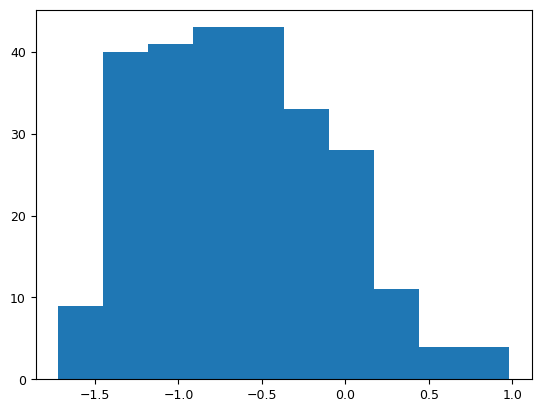

In [346]:
plt.hist(Alphas.reshape(-1))

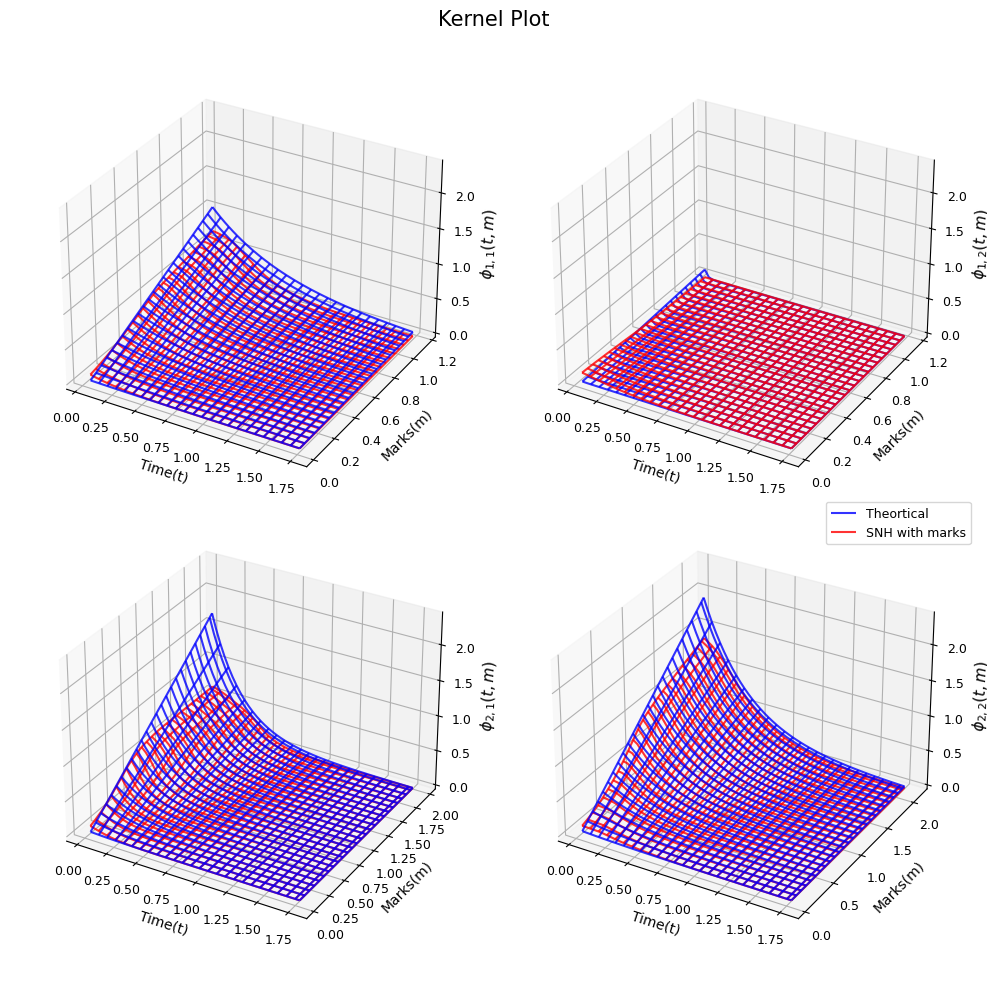

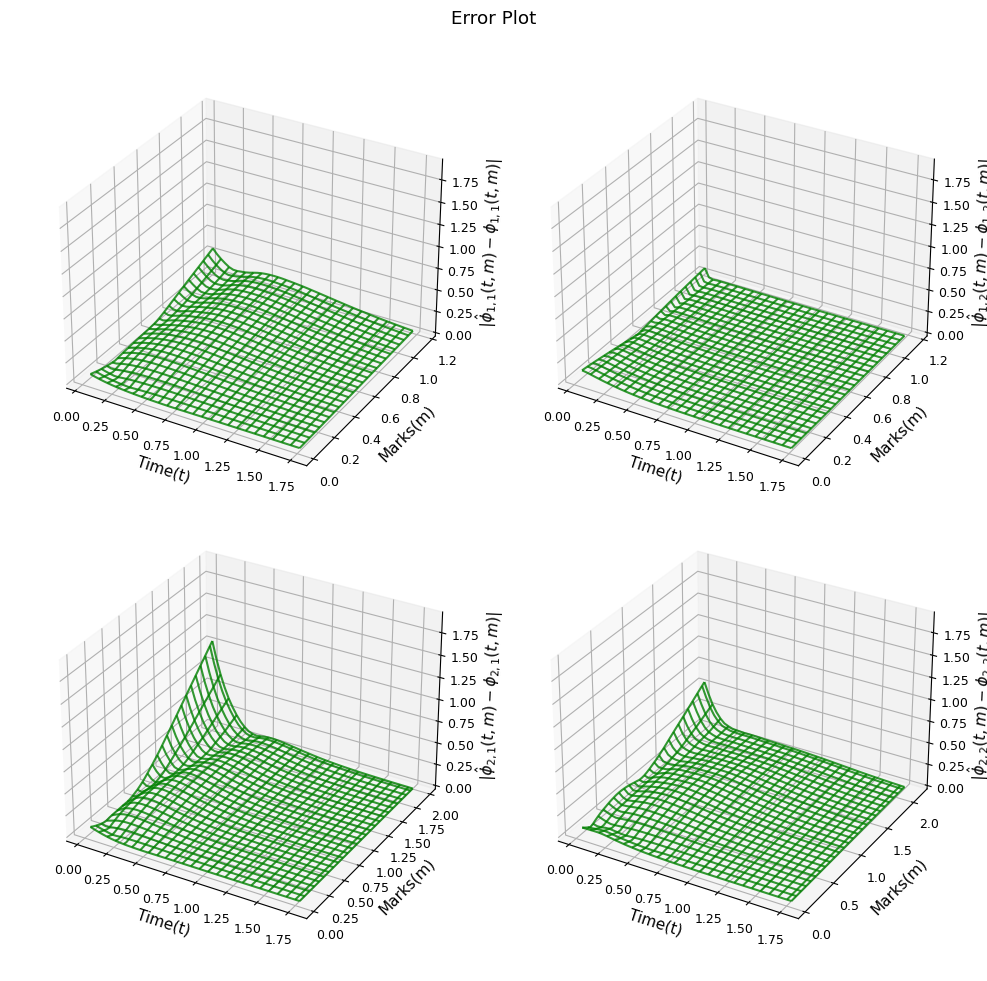

In [372]:
def optimalValues(d,k):
    optimalAlphas=SGDNNNH[0][1][:,d,k].reshape(-1,1)
    optimalAlpha0=SGDNNNH[0][0][:,d,k].reshape(-1,1)
    optimalBetas1=SGDNNNH[0][2][:,d,k].reshape(-1,1)
    optimalBetas2=SGDNNNH[0][3][:,d,k].reshape(-1,1)
    optimalBeta0=SGDNNNH[0][4][:,d,k].reshape(-1,1)
    optimalMu=SGDNNNH[0][5][d]/fac
    return optimalAlphas,optimalAlpha0,optimalBetas1,optimalBetas2,optimalBeta0,optimalMu

def nnKernelOptimal(x,mark,d,k):
    alphas,alpha0,betas1,betas2,beta0,mu=optimalValues(d,k)

    x=x.reshape(1,-1)
    markI=mark.reshape(1,-1)
    n1 = np.maximum(np.dot(betas1,x) + np.dot(betas2,markI)+ beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    y = np.exp(y)
    return y    

def nnKernelMatrixOptimal(x,y,d,k):
    z=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        z[i,:]=nnKernelOptimal(x[i,:],y[i,:],d,k).reshape(-1)
            
    return z

dx=0.03


fig, ax = plt.subplots(2,2,figsize=(10,10),subplot_kw=dict(projection='3d'))    
error=[[]for j in range(len(marks1))]
marksArr=[[]for j in range(len(marks1))]
timeArr=[[]for j in range(len(marks1))]
actualArr=[[]for j in range(len(marks1))]
TheorArr=[[]for j in range(len(marks1))]
Zlimit=[[]for j in range(len(marks1))]

plt.rc('axes', titlesize=11)    
plt.rc('axes', labelsize=11)   
plt.rc('xtick', labelsize=9)    
plt.rc('ytick', labelsize=9)    
plt.rc('legend', fontsize=9 )   
plt.rc('font', size=11) 

for d in range(totalD):
    for k in range(totalD):
        marksplot=np.sort(marks1[d][k])
        lengthMarks=len(marksplot)
        marksMin=marksplot[int(0.05*lengthMarks)]
        marksMax=marksplot[int(0.95*lengthMarks)]
        diff_t=np.diff(tScale[d])
        diff_tSort=np.sort(diff_t)
        length_difftSort=len(diff_tSort)
        diffMin= diff_tSort[int(0.05*length_difftSort)]
        diffMax= diff_tSort[int(0.95*length_difftSort)]
        tk =np.arange(diffMin,1.5,dx)
        marksP=np.linspace(marksMin,marksMax,len(tk))
        X, Y = np.meshgrid(tk, marksP)
        timeArr[d].append(X/fac)
        marksArr[d].append(Y/meanMarks[d][k])
        if(kernelType == 0):
            Z1=Y/meanMarks[d][k]*function_kernel1(thetas[d][k],X)
        TheorArr[d].append(Z1)
        Z2=nnKernelMatrixOptimal(X,Y,d,k)*fac
        actualArr[d].append(Z2)
        
            
        surf = ax[d][k].plot_wireframe(timeArr[d][k],  marksArr[d][k],TheorArr[d][k], cmap="Blues",
                       rstride=2, cstride=2, alpha=0.8,color="blue",label="Theortical")
        
        error[d].append(abs(Z2-Z1))
        Zlimit[d].append(max(Z1.reshape(-1))) 
        surf1= ax[d][k].plot_wireframe(timeArr[d][k],  marksArr[d][k],actualArr[d][k], cmap="Reds",
                       rstride=2, cstride=2, alpha=0.8,color="red",label="SNH with marks")
    
        ax[d][k].set_xlabel('Time(t)',fontsize=10)
        ax[d][k].set_ylabel('Marks(m)',fontsize=10)
        ax[d][k].set_zlabel(r"$\phi_{%g,%g}(t,m)$" %(d+1,k+1))
        ax[d][k].set_box_aspect(aspect=None,zoom=0.9)
        ax[d][k].set_zlim(-0.01,2.4)
        plt.grid()

fig.subplots_adjust(right=0.8)
fig.suptitle('Kernel Plot', fontsize=15)
plt.legend()


fig.tight_layout()
plt.savefig("results/multid_exp.jpg",dpi=100, transparent=False)
plt.pause(0.0005)


fig, ax = plt.subplots(2,2,figsize=(10,10),subplot_kw=dict(projection='3d'))
    


for d in range(totalD):
    for k in range(totalD):

        errorSurf = ax[d][k].plot_wireframe(timeArr[d][k], marksArr[d][k], error[d][k], cmap="Greens",
                    rstride=2, cstride=2, alpha=0.8,color="green",label="Error")
    
        ax[d][k].set_xlabel('Time(t)')
        ax[d][k].set_ylabel('Marks(m)')
        ax[d][k].set_zlabel(r"$|\hat{\phi}_{%g,%g}(t,m)-\phi_{%g,%g}(t,m)|$" %(d+1,k+1,d+1,k+1))
        ax[d][k].set_zlim(0,max(np.array(Zlimit).reshape(-1)))
        ax[d][k].set_box_aspect(aspect=None,zoom=0.9)
        plt.grid()


fig.subplots_adjust(right=0.8)
fig.suptitle('Error Plot')
fig.tight_layout()
plt.rc('axes', titlesize=11)    
plt.rc('axes', labelsize=11)   
plt.rc('xtick', labelsize=9)    
plt.rc('ytick', labelsize=9)    
plt.rc('legend', fontsize=9 )   
plt.rc('font', size=11)  
plt.savefig("results/multid_error.jpg",dpi=100, transparent=False)
plt.pause(0.0005) 


In [ ]:
import SNHMultivariate as SNHM
SNHNonMarked=SNHM.sgdNeuralHawkesBiVariate(tScale)
def optimalParamsMultiNM(results):
    AlphasOptimal=results[0][1]
    Alphas0_Optimal=results[0][0]
    Betas1_Optimal=results[0][2]
    Betas0_Optimal=results[0][3]
    mu_Optimal=results[0][4]
    return AlphasOptimal,Alphas0_Optimal,Betas1_Optimal,Betas0_Optimal,mu_Optimal
AlphasNMOptimal,Alphas0NMOptimal,Betas1NMOptimal,Betas0NMOptimal,muNMoptimal=optimalParamsMultiNM(SNHNonMarked)

def nnKernelOptimalNM(x,d,k):
    alphas = (AlphasNMOptimal[:,d,k]).reshape(-1,1)
    alpha0 = (Alphas0NMOptimal[:,d,k]).reshape(-1,1)
    betas1 = (Betas1NMOptimal[:,d,k]).reshape(-1,1)
    beta0 = (Betas0NMOptimal[:,d,k]).reshape(-1,1)
    x=np.array(x).reshape(1,-1)

    n1 = np.maximum(np.dot(betas1,x)+ beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    y = np.exp(y)
    return y 

In [ ]:
totalLength=0
for j in range(len(tScale)):
    totalLength+=len(tScale[j])
combinedT=np.ones((totalLength,2))

start=0
for j in range(len(tScale)):
    end=start+len(tScale[j])
    combinedT[start:end,0]=tScale[j]
    combinedT[start:end,1]=np.ones(end-start)*j
    
    start=end
sortedT=combinedT[combinedT[:, 0].argsort()]
train_len=int(totalLength*0.7)
test_len=int(totalLength*0.85)
train1=sortedT[:train_len]
val1=sortedT[train_len:test_len]
test1=sortedT[test_len:]
trainT=[]
trainMark=[[]for k in range(len(tScale))]
valT=[]
valMark=[[]for k in range(len(tScale))]
testT=[]
testMark=[[]for k in range(len(tScale))]

for j in range(len(tScale)):
    trainT.append(train1[train1[:,1]==j][:,0])
  
    valT.append(val1[val1[:,1]==j][:,0])
    
    testT.append(test1[test1[:,1]==j][:,0])
for d in range(len(tScale)):
    for p in range(len(tScale)):
        trainMark[d].append(marksScale[d][p][:len(trainT[p])])
        valMark[d].append(marksScale[d][p][len(trainT[p]):len(trainT[p])+len(valT[p])])
        testMark[d].append(marksScale[d][p][-len(testT[p]):])


def integratedLambdas(t,marks):
   
    totalD=len(t)
    muMSNH = SGDNNNH[0][5]/fac
    muNMSNH = muNMoptimal  

    lambdaMSNH=[[] for k in range(totalD)]
    lambdaEM=[[] for k in range(totalD)]
    lambdaNMSNH=[[] for k in range(totalD)]
    for p in range(totalD):
        tp=t[p]
        for i in range(1,len(tp),1):
            kerNMSNH = 0
            kerMSNH=0
            kerEM =0
            tp1=tp[i]
            tp2=tp[i-1]
            interval=np.linspace(tp2,tp1,50)
            multi=interval[1]-interval[0]
            for k in range(totalD):
                if p==k:
            
                    for j in range(len(interval)):
                        new_i=i+len(trainT[p])+len(valT[p])
                        li=max(0,new_i-support)
                        temp1 = interval[j]-tScale[p][li:new_i]
                        mark1 = marksScale[p][p][li:new_i]
                        temp1=temp1[temp1>0]
                        mark1=mark1[:len(temp1)]
                        kerNMSNH += (nnKernelOptimalNM(temp1,p,p)).sum()*multi
                        kerMSNH +=(nnKernelOptimal(temp1,mark1,p,p)).sum()*multi
                else:
                    #lengthK=len(trainT[k])+len(valT[k])
                    #lengthK=0
                    jT = mapping[p,k][tp[i]]
                    if(jT != None):
                        if jT>len(tScale[k])-1:
                            jT=len(tScale[k])-1
                        for j in range(len(interval)):
                            new_jT=jT
                            li=max(0,new_jT-support)
                            temp1 = interval[j]-tScale[k][li:new_jT+1]
                            mark1= marksScale[p][k][li:new_jT+1]
                            temp1=temp1[temp1>0]
                            mark1=mark1[:len(temp1)]
                            kerNMSNH += (nnKernelOptimalNM(temp1,p,k)).sum()*multi
                            
                            kerMSNH +=(nnKernelOptimal(temp1,mark1,p,k)).sum()*multi

            kerNMSNH +=(muNMSNH[p])*(tp1-tp2)
            kerMSNH +=(muMSNH[p])*(tp1-tp2)
        
            lambdaNMSNH[p].append(kerNMSNH)
      
            lambdaMSNH[p].append(kerMSNH)
            
    return lambdaMSNH,lambdaNMSNH

tlim=200
def data_check(marks):
    if len(marks)!=len(marks[0]):
        marksnew=[[] for j in range(len(marks))]
        for d in range(len(marks)):
            for k in range(len(marks)):
                marksnew[d].append(marks[k].reshape(-1))
        return marksnew
    else:
        return marks

lim = max(trainT[0][0:tlim][-1],trainT[1][0:tlim][-1])
inSampleT=[trainT[0][trainT[0]<lim],trainT[1][trainT[1]<lim]]
inSampleMark1=[trainMark[0][0][trainMark[0][0]<lim],trainMark[1][1][trainMark[1][1]<lim]]
inSampleMark=data_check(inSampleMark1)

lambdaMSNH,lambdaNMSNH =integratedLambdas(testT,testMark) 


p_MSNH_1=np.exp(-np.array(lambdaMSNH[0]))

p_NMSNH_1=np.exp(-np.array(lambdaNMSNH[0]))


p_MSNH_2=np.exp(-np.array(lambdaMSNH[1]))

p_NMSNH_2=np.exp(-np.array(lambdaNMSNH[1]))




In [ ]:
def plot_qqPlot(subM,subNM,subEM):
    qq=[]
    qqNonMarked=[]
    qqEM=[]
    probs=np.arange(0.02,1,0.02)

    for k in (probs):
        qq.append(len(subM[subM<=k])/len(subM))
        qqNonMarked.append(len(subNM[subNM<=k])/len(subNM))
        qqEM.append(len(subEM[subEM<=k])/len(subEM))
    plt.plot(probs,qq,'r--',label="SNH Marked")
    plt.plot(probs,qqNonMarked,'g--',label="SNH unMarked")
    plt.plot(probs,qqEM,'g--',label="EM unMarked")
    plt.plot(probs,probs,'b-')
    plt.xlabel('Theortical Quantiles')
    plt.ylabel('Actual Quantiles')
    plt.legend()
    plt.pause(0.005)
P_MSNH =[p_MSNH_1,p_MSNH_2]
P_NMSNH=[p_NMSNH_1,p_NMSNH_2]
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
fig.tight_layout()
probs=np.arange(0.02,1,0.02)
for i,ax1 in enumerate(axs):
    qq1=[]
    qq2=[]

    probs=np.arange(0.01,1.02,0.02)
    p1=P_MSNH[i]
    p2=P_NMSNH[i]
    for k in (probs):
        qq1.append(len(p1[p1<=k])/len(p1))
        qq2.append(len(p2[p2<=k])/len(p2))
    ax1.plot(probs,qq2,'g--',label="Non-Marked",linewidth=2)
    ax1.plot(probs,qq1,'r--',label="Marked",linewidth=2)
 
    ax1.plot(np.arange(0,1.01,0.2),np.arange(0,1.01,0.2))
    ax1.legend()
    ax1.grid()
axs[0].set_title("Dimension-1")
axs[1].set_title("Dimension-2")
plt.rc('axes', titlesize=13)    
plt.rc('axes', labelsize=13)   
plt.rc('xtick', labelsize=10)    
plt.rc('ytick', labelsize=10)    
plt.rc('legend', fontsize=13)    
plt.rc('font', size=13) 
fig.text(0.5, -0.01, 'Theortical Quantiles', ha='center')
fig.text(-0.01, 0.5, 'Sample Quantiles', va='center', rotation='vertical')
plt.savefig('results/multid_QQ.jpg',dpi=100, bbox_inches='tight')
plt.pause(0.005)